delta_nu/2 instead of delta_nu

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
from datetime import datetime
import celerite
from celerite import terms
from scipy.optimize import minimize
from scipy.signal import find_peaks
from astropy.timeseries import LombScargle
from datetime import timedelta, date
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from NEID_solar_functions import *
from GP_kernels import *


In [3]:
SONG = np.loadtxt('./lib/sun_SONG_full_lowess_filtered_final_used.dat')
bjd = SONG[:,0]
rv = SONG[:,1]

In [4]:
start_date = datetime(2018, 5, 27)
end_date = datetime(2018, 5, 27)

for date in daterange(start_date, end_date):
    T1 = pyasl.jdcnv(date)
    idx_bjd = (bjd>T1) & (bjd<T1+1)
    
    t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
    y = rv[idx_bjd]
    yerr = np.ones(len(t))*0.7
    
    t0 = t
    y0 = y
    yerr0 = yerr

In [5]:
idx_test = ((t > 450) & (t < 500))
t = t[~idx_test]
y = y[~idx_test]
yerr = yerr[~idx_test]

In [6]:
idx = np.sort(random.sample(range(0, len(t)), 3000))

In [7]:
t = t[idx] - min(t[idx])
y = y[idx]
yerr = yerr[idx]

In [8]:
# plt.rcParams.update({'font.size': 18})
# fig = plt.figure(figsize=(10, 6))
# plt.plot(t, y, '.')

In [9]:
import jax
import jax.numpy as jnp
from tinygp import kernels, GaussianProcess
import tinygp

jax.config.update("jax_enable_x64", True)


2023-04-10 23:57:16.522648: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /storage/icds/RISE/sw8/julia-1.8.1/julia-1.8.1/lib:/storage/icds/RISE/sw8/anaconda/anaconda3/lib
2023-04-10 23:57:16.643806: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /storage/icds/RISE/sw8/julia-1.8.1/julia-1.8.1/lib:/storage/icds/RISE/sw8/anaconda/anaconda3/lib
2023-04-10 23:57:16.645231: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /storage/icds/RISE/sw8/jul

In [11]:
# Factor to convert uHz to minute^-1
uHz_conv = 1e-6 * 60

def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    A = jnp.exp(theta["log_A"])
    W = jnp.exp(theta["log_W"])
    # sigma = jnp.exp(theta["log_sigma"])
    nu_max = jnp.exp(theta["log_nu_max"])
    delta_nu = jnp.exp(theta["log_delta_nu"])
    epsilon = theta["epsilon"]

    # Construct the kernel by multiplying and adding `Kernel` objects
    
    kernel = 0     
    N = 19 # 25*135/2=1620
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = A*jnp.exp( - (i*delta_nu/2 + epsilon)**2 / (2*W**2) ) # uHz_conv is cancelled out; change A/Q**2 to A**2
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(
        kernel, X, diag=jnp.exp(theta["log_diag"]))    

def neg_log_likelihood(theta, X, y):
    gp = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    "log_diag": np.log(0.7),
    "log_Q": np.log(500),
    "log_A": np.log(1),
    "log_W": np.log(135*2),
    "log_nu_max": np.log(3000),
    "log_delta_nu": np.log(135),
    "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

2023-04-10 23:57:42.798241: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /storage/icds/RISE/sw8/julia-1.8.1/julia-1.8.1/lib:/storage/icds/RISE/sw8/anaconda/anaconda3/lib
2023-04-10 23:57:42.798264: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


Initial negative log likelihood: 4231.253933053384
Gradient of the negative log likelihood, wrt the parameters:
{'epsilon': DeviceArray(-1.06780315, dtype=float64), 'log_A': DeviceArray(-280.78052138, dtype=float64), 'log_Q': DeviceArray(140.05691217, dtype=float64), 'log_W': DeviceArray(-587.08035563, dtype=float64), 'log_delta_nu': DeviceArray(879.484998, dtype=float64), 'log_diag': DeviceArray(-197.1153561, dtype=float64), 'log_nu_max': DeviceArray(-6799.00506488, dtype=float64)}


In [12]:
theta_init

{'log_diag': -0.35667494393873245,
 'log_Q': 6.214608098422191,
 'log_A': 0.0,
 'log_W': 5.598421958998374,
 'log_nu_max': 8.006367567650246,
 'log_delta_nu': 4.90527477843843,
 'epsilon': 0.0}

In [13]:
# bounds = {
#     "mean": np.float64([-1, 1]),
#     "log_diag": np.log([0.1, 1]),
#     "log_omega": (np.log([0.8, 0.8]), np.log([1.6, 1.6])),
#     "log_Q": (np.log([100, 100]), np.log([1000, 1000])),
#     "log_sigma": (np.float64([0.1, 0.1]), np.float64([1, 1])),
# }

In [14]:
epsilon_l, epsilon_h = jnp.float64([-10, 10])
bounds_l = jnp.log(jnp.array([1e-4, 4e2,  1e2, 130, 0.4, 2500.0]))
bounds_h = jnp.log(jnp.array([1e2,  10**4,  6e2, 140, 1.0, 3500.0]))
lower_bounds, upper_bounds = jnp.hstack((epsilon_l, bounds_l)), jnp.hstack((epsilon_h, bounds_h))
bounds = (lower_bounds, upper_bounds)
bounds

(DeviceArray([-10.        ,  -9.21034037,   5.99146455,   4.60517019,
                4.86753445,  -0.91629073,   7.82404601], dtype=float64),
 DeviceArray([10.        ,  4.60517019,  9.21034037,  6.39692966,
               4.94164242,  0.        ,  8.16051825], dtype=float64))

In [15]:
# w_init = jnp.zeros(7)
# lower_bounds = jnp.ones_like(w_init)* (-1)
# upper_bounds = jnp.ones_like(w_init) * jnp.inf
# bounds = (lower_bounds, upper_bounds)

In [16]:
import jaxopt
solver = jaxopt.ScipyBoundedMinimize(fun=neg_log_likelihood)
soln = solver.run(theta_init, bounds=bounds, X=t, y=y)
print(f"Final negative log likelihood: {soln.state.fun_val}")

Final negative log likelihood: 3784.8430792359445


In [17]:
soln.params

{'epsilon': DeviceArray(0.22794111, dtype=float64),
 'log_A': DeviceArray(0.99920296, dtype=float64),
 'log_Q': DeviceArray(5.99146455, dtype=float64),
 'log_W': DeviceArray(5.76212197, dtype=float64),
 'log_delta_nu': DeviceArray(4.86753445, dtype=float64),
 'log_diag': DeviceArray(-0.62175366, dtype=float64),
 'log_nu_max': DeviceArray(8.06256063, dtype=float64)}

In [18]:
for key, value in soln.params.items():
    print(key[4:], np.exp(value))
    
print(1/(np.exp(soln.params['log_nu_max'])*uHz_conv))

lon 1.2560113596312061
A 2.7161161195441585
Q 399.9999999999999
W 318.02244761238245
delta_nu 129.99999999999997
diag 0.5370018904547358
nu_max 3173.40565534419
5.251981144799147


In [19]:
np.exp(soln.params['log_A']) * jnp.exp( - (1*np.exp(soln.params['log_delta_nu'])/2 + np.exp(soln.params['epsilon']))**2 / (2*np.exp(soln.params['log_W'])**2) )

DeviceArray(2.65780528, dtype=float64)

In [20]:
for j in range(12):
    coeff = jnp.exp( - (j*np.exp(soln.params['log_delta_nu'])/2 + np.exp(soln.params['epsilon']))**2 / (2*np.exp(soln.params['log_W'])**2) )
    print(coeff)

0.9999922009825177
0.9785315364392448
0.9183550319848891
0.8266162954228232
0.713600070396498
0.5908311377473212
0.4691691370838105
0.3573164949804826
0.26099624801882626
0.18284076611219122
0.12284836189981109
0.07916318820910238


In [21]:
x = np.linspace(min(t), max(t), 1000)
gp = build_gp(soln.params, t)
cond_gp = gp.condition(y, x).gp
pred_mean, pred_std = cond_gp.loc, cond_gp.variance

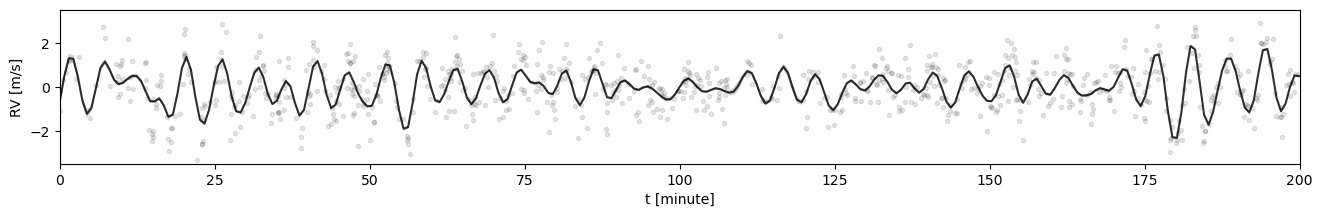

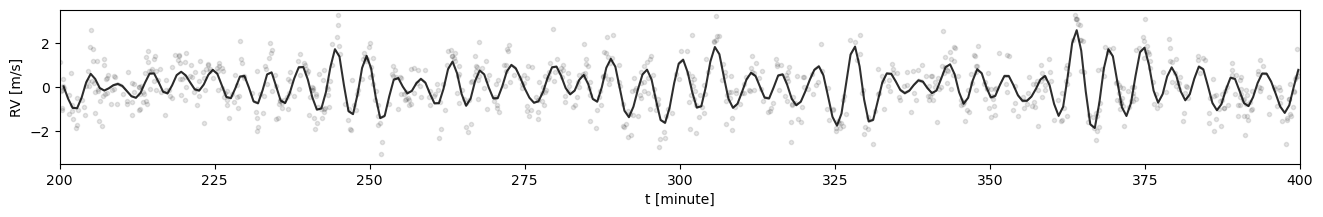

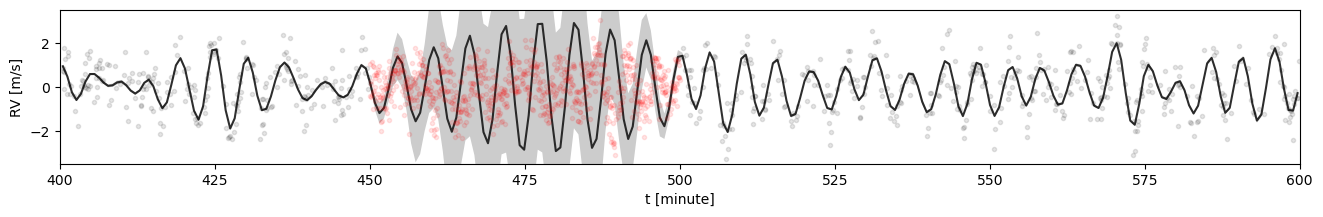

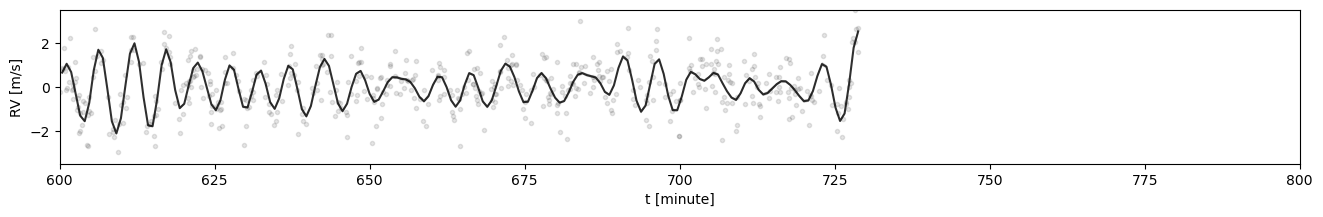

In [22]:
for i in range(4):
    fig = plt.figure(figsize=(16, 2))
    idx_t = ((t>=i*200) & (t<(i+1)*200))
    idx_x = ((x>=i*200) & (x<(i+1)*200))
    plt.plot(t[idx_t], y[idx_t], 'k.', alpha=0.1)
    plt.plot(x[idx_x], pred_mean[idx_x], color='k', alpha=0.8)
    plt.plot(t0[idx_test], y0[idx_test], '.', color='r', alpha=0.1)
    plt.fill_between(x[idx_x], pred_mean[idx_x]+pred_std[idx_x], pred_mean[idx_x]-pred_std[idx_x], color='k', alpha=0.2,
                     edgecolor="none")
    plt.xlabel('t [minute]')
    plt.ylabel('RV [m/s]')
    plt.xlim([i*200, (i+1)*200])
    plt.ylim([-3.5, 3.5])
    plt.show()